In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import random

2025-08-21 08:14:07.619051: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-21 08:14:20.806771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-21 08:14:31.802378: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [10]:

IMG_WIDTH, IMG_HEIGHT = 200, 200
BATCH_SIZE = 32
EPOCHS = 3
TRAIN_DIR = '../data/train'

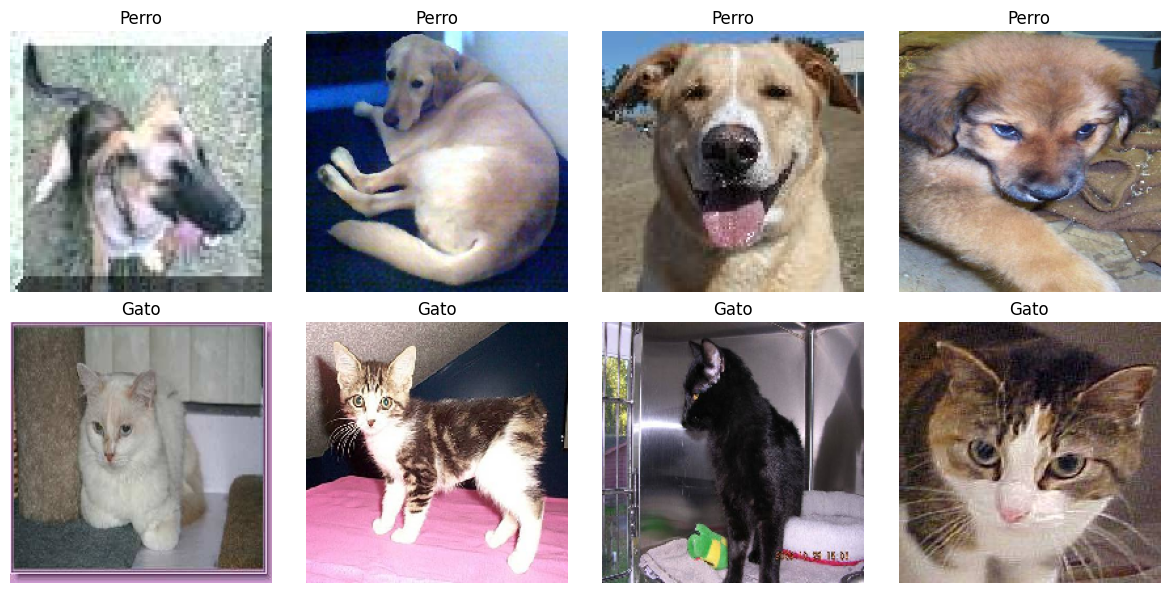

In [3]:

def visualize_samples():
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    
    # Mostrar perros
    dog_files = [f for f in os.listdir(TRAIN_DIR) if f.startswith('dog')]
    for i in range(4):
        img_path = os.path.join(TRAIN_DIR, random.choice(dog_files))
        img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
        axes[0, i].imshow(img)
        axes[0, i].set_title('Perro')
        axes[0, i].axis('off')
    
    # Mostrar gatos
    cat_files = [f for f in os.listdir(TRAIN_DIR) if f.startswith('cat')]
    for i in range(4):
        img_path = os.path.join(TRAIN_DIR, random.choice(cat_files))
        img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
        axes[1, i].imshow(img)
        axes[1, i].set_title('Gato')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples()

In [5]:
# Primero verificar la estructura actual y crear subcarpetas si es necesario
import shutil

def organize_dataset():
    # Crear subcarpetas si no existen
    dog_dir = os.path.join(TRAIN_DIR, 'dogs')
    cat_dir = os.path.join(TRAIN_DIR, 'cats')
    
    os.makedirs(dog_dir, exist_ok=True)
    os.makedirs(cat_dir, exist_ok=True)
    
    # Mover archivos a las subcarpetas correspondientes
    for filename in os.listdir(TRAIN_DIR):
        if filename.endswith('.jpg'):
            src_path = os.path.join(TRAIN_DIR, filename)
            
            if filename.startswith('dog'):
                dest_path = os.path.join(dog_dir, filename)
                shutil.move(src_path, dest_path)
            elif filename.startswith('cat'):
                dest_path = os.path.join(cat_dir, filename)
                shutil.move(src_path, dest_path)

# Organizar el dataset
organize_dataset()

# Verificar la nueva estructura
print("Estructura de carpetas después de organizar:")
for root, dirs, files in os.walk(TRAIN_DIR):
    level = root.replace(TRAIN_DIR, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Mostrar solo primeros 5 archivos
        if file.endswith('.jpg'):
            print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... y {len(files) - 5} más')

Estructura de carpetas después de organizar:
train/
  cats/
    cat.12256.jpg
    cat.12221.jpg
    cat.12318.jpg
    cat.12398.jpg
    cat.12493.jpg
    ... y 495 más
  dogs/
    dog.139.jpg
    dog.186.jpg
    dog.436.jpg
    dog.474.jpg
    dog.1.jpg
    ... y 495 más


In [6]:
# Ahora preparar los generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Usamos 20% para validación
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Verificar que se encontraron imágenes
print(f"Imágenes de entrenamiento: {train_generator.samples}")
print(f"Imágenes de validación: {validation_generator.samples}")
print(f"Classes: {train_generator.class_indices}")

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Imágenes de entrenamiento: 800
Imágenes de validación: 200
Classes: {'cats': 0, 'dogs': 1}


In [7]:

model = Sequential()

# Bloque 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Bloque 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Bloque 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Capas fully connected
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Salida binaria: perro o gato

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-21 08:27:41.100778: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


2025-08-21 08:27:41.555620: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 115605504 exceeds 10% of free system memory.
2025-08-21 08:27:41.737923: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 115605504 exceeds 10% of free system memory.
2025-08-21 08:27:41.786797: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 115605504 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 196, 196, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 43, 43, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    28,901,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,189,409 (111.35 MB)

 Trainable params: 29,189,409 (111.35 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/3


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4946 - loss: 0.6932
Epoch 1: val_accuracy did not improve from 0.47917
25/25 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.4975 - loss: 0.6933 - val_accuracy: 0.4792 - val_loss: 0.6933
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4983 - loss: 0.6932
Epoch 2: val_accuracy did not improve from 0.47917
25/25 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.4950 - loss: 0.6932 - val_accuracy: 0.4792 - val_loss: 0.6932
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5019 - loss: 0.6932
Epoch 3: val_accuracy did not improve from 0.47917
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.4950 - loss: 0.6932 - val_accuracy: 0.4792 - val_loss: 0.6932
Restoring model weights from the end of the best epoch: 3.


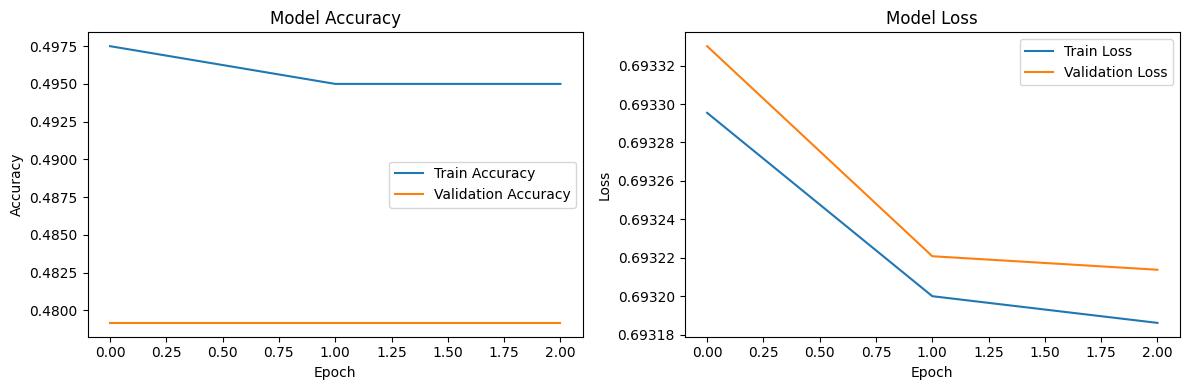

In [12]:
# Visualizar métricas de entrenamiento
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Gráfico de accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Gráfico de loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [13]:
# Cargar el mejor modelo y hacer predicciones
from tensorflow.keras.models import load_model

# Cargar el mejor modelo guardado
best_model = load_model('best_model.h5')

# Evaluar el modelo con datos de validación
val_loss, val_accuracy = best_model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Loss: {val_loss:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5000 - loss: 0.6932
Validation Accuracy: 0.5000
Validation Loss: 0.6932


Predicción para un perro:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


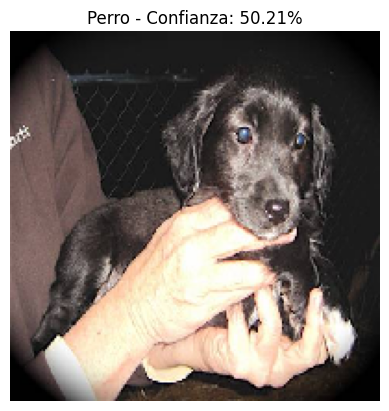

Predicción para un gato:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


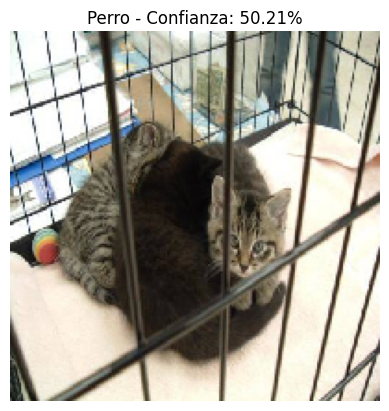

np.float32(0.5020544)

In [17]:
# Función para hacer predicciones en imágenes individuales
def predict_image(image_path, model):
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)[0][0]
    
    plt.imshow(img)
    if prediction > 0.5:
        plt.title(f'Perro - Confianza: {prediction:.2%}')
    else:
        plt.title(f'Gato - Confianza: {(1-prediction):.2%}')
    plt.axis('off')
    plt.show()
    
    return prediction

# Probar con una imagen de ejemplo
sample_dog = [f for f in os.listdir('../data/train/dogs') if f.startswith('dog')][0]
sample_cat = [f for f in os.listdir('../data/train/cats') if f.startswith('cat')][0]

print("Predicción para un perro:")
predict_image(os.path.join('../data/train/dogs', sample_dog), best_model)

print("Predicción para un gato:")
predict_image(os.path.join('../data/train/cats', sample_cat), best_model)